In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

from emtf_algos import *

In [2]:
import sys
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

# Set random seed
np.random.seed(2027)

from collections import OrderedDict

import tensorflow as tf
import keras
from keras import backend as K
import matplotlib as mpl
import matplotlib.pyplot as plt

# Set random seed
tf.set_random_seed(2027)

logger = get_logger()
logger.info('Using cmssw      : {0}'.format(os.environ['CMSSW_VERSION'] if 'CMSSW_VERSION' in os.environ else 'n/a'))
logger.info('Using python     : {0}'.format(sys.version.replace('\n', '')))
logger.info('Using numpy      : {0}'.format(np.__version__))
logger.info('Using tensorflow : {0}'.format(tf.__version__))
logger.info('Using keras      : {0}'.format(keras.__version__))
logger.info('.. list devices  : {0}'.format(K.get_session().list_devices()))
logger.info('Using matplotlib : {0}'.format(mpl.__version__))

%matplotlib inline

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-requests/2.21.0-pafccj2/lib/python2.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.2) or chardet (2.2.1) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.
[INFO    ] Using cmssw      : CMSSW_10_6_3
[INFO    ] Using python     : 2.7.14+ (default, Apr 19 2019, 15:48:06) [GCC 7.4.1 20190129]
[INFO    ] Using numpy      : 1.16.2
[INFO    ] Using tensorflow : 1.6.0
[INFO    ] Using keras      : 2.2.4
[INFO    ] .. list devices  : [_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]
[INFO    ] Using matplotlib : 2.2.4


In [3]:
# Settings

# zone: (0,1,2) -> eta=(1.98-2.5, 1.55-1.98, 1.2-1.55)
zone = 0

# timezone: (0,1,2) -> BX=(-1,0,+1)
timezone = 1

#maxevents = 200000
maxevents = -1

# Input files
signal = 'signal_add.20200721.npz'
signal_displ = 'signal_displ_add.20200721.npz'
bkgnd = 'bkgnd_add.20200716.npz'

# Input data columns
part_metadata = ['part_invpt', 'part_eta', 'part_phi',
                 'part_vx', 'part_vy', 'part_vz',
                 'part_d0', 'part_sector', 'part_zone']
part_metadata = OrderedDict(zip(part_metadata, range(len(part_metadata))))
#print(part_metadata)

hits_metadata = ['emtf_layer', 'ri_layer', 'zones', 'timezones',
                 'emtf_chamber', 'emtf_segment', 'detlayer', 'bx',
                 'emtf_phi', 'emtf_bend', 'emtf_theta', 'emtf_theta_alt',
                 'emtf_qual', 'emtf_time', 'fr', 'rsvd']
hits_metadata = OrderedDict(zip(hits_metadata, range(len(hits_metadata))))
#print(hits_metadata)

# Image format
num_channels = 1
num_cols = 300
num_rows = 8
image_format = (num_rows, num_cols, num_channels)

# Image sliding window
image_stride = (min_emtf_strip, max_emtf_strip, coarse_emtf_strip)

# Parameter
num_params = 5

# q/pT and d0 binning
#invpt_bins = np.array([-0.5, -0.3, -0.1, 0.1, 0.3, 0.5])
#dzero_bins = np.array([-150., -90., -30., 30., 90., 150.])

logger.info('Processing zone {0} timezone {1}'.format(zone, timezone))
logger.info('.. maxevents    : {0}'.format(maxevents))
logger.info('.. image_format : {0}'.format(image_format))
logger.info('.. image_stride : {0}'.format(image_stride))
logger.info('.. num_params   : {0}'.format(num_params))

[INFO    ] Processing zone 0 timezone 1
[INFO    ] .. maxevents    : -1
[INFO    ] .. image_format : (8, 300, 1)
[INFO    ] .. image_stride : (320, 5120, 16)
[INFO    ] .. num_params   : 5


In [4]:
# Styling
plt.style.use('tdrstyle.mplstyle')

# Color maps
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(plt.cm.viridis.colors, name='viridis_mod')
my_cmap.set_under('w',1)

from matplotlib.colors import LinearSegmentedColormap
cdict = {
  'blue' : ((0.0, 0.0416, 0.0416), (0.365079, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'green': ((0.0, 0.0, 0.0), (0.365079, 0.0, 0.0), (0.746032, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'red'  : ((0.0, 0.0, 0.0), (0.746032, 0.0, 0.0), (1.0, 1.0, 1.0)),
}
blue_hot = LinearSegmentedColormap('blue_hot', cdict)

cdict = {
  'blue' : ((0.0, 0.0, 0.0), (0.365079, 0.0, 0.0), (0.746032, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'green': ((0.0, 0.0416, 0.0416), (0.365079, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'red'  : ((0.0, 0.0, 0.0), (0.746032, 0.0, 0.0), (1.0, 1.0, 1.0)),
}
green_hot = LinearSegmentedColormap('green_hot', cdict)

### Load data

In [5]:
def load_signal(f):
  logger.info('Loading from {0}'.format(f))
  with np.load(f) as loaded:
    out_part = loaded['out_part']
    out_hits = RaggedTensorValue(loaded['out_hits_values'], loaded['out_hits_row_splits'])
    out_simhits = RaggedTensorValue(loaded['out_simhits_values'], loaded['out_simhits_row_splits'])
    logger.info('out_part: {0} out_hits: {1} out_simhits: {2}'.format(out_part.shape, out_hits.shape, out_simhits.shape))
  return (out_part, out_hits, out_simhits)

def load_bkgnd(f):
  logger.info('Loading from {0}'.format(f))
  with np.load(f) as loaded:
    out_aux = loaded['out_aux']
    out_hits = RaggedTensorValue(loaded['out_hits_values'], loaded['out_hits_row_splits'])
    logger.info('out_aux: {0} out_hits: {1}'.format(out_aux.shape, out_hits.shape))
  return (out_aux, out_hits)

In [6]:
part_data, hits_data, simhits_data = load_signal(signal)

#bkg_aux_data, bkg_hits_data = load_bkgnd(bkgnd)

[INFO    ] Loading from signal_add.20200721.npz
[INFO    ] out_part: (2000000, 9) out_hits: (2000000, None, 16) out_simhits: (2000000, None, 16)


In [7]:
# Debug
with np.printoptions(linewidth=100, threshold=1000):
  for i in range(5):
    print('Event {0}'.format(i))
    print(part_data[i])
    print(hits_data[i])
    print(simhits_data[i])

Event 0
[-2.5611117e-01  2.1183386e+00 -6.1635029e-01  6.7432784e-04  9.9125458e-04 -4.6484246e+00
 -1.1986600e-03  5.0000000e+00  0.0000000e+00]
[[   0    0    4    3    2    0    0    0 2548    5   18   17   -6    0    0  -99]
 [   0    0    4    3    2    1    0    0 2548    5   17   18   -6    0    0  -99]
 [   2    3    4    3   19    0    0    0 2684    2   16   16    6    0    1  -99]
 [   3    5    4    3   28    0    0    0 2819   15   17   16   -5    0    0  -99]
 [   3    5    4    3   28    1    0    0 2728    0   16   17   -5    0    0  -99]
 [   4    7    4    3   37    0    0    0 2736    0   16   16   -5    0    0  -99]
 [   9    9    4    2   55    0    0    0 2505    0   18   18    0    0    1  -99]
 [  10   12    4    2   73    0    0    0 2675    0   19   19    0    0    1  -99]
 [   7   14    4    2   82    0    0    0 2888    0   17   17    0    1    0  -99]
 [   7   14    4    2   82    1    0    0 2714    0   17   17    0    1    0  -99]
 [   8   16    4    2   

In [8]:
# Debug
try:
  with np.printoptions(linewidth=100, threshold=1000):
    for i in range(10):
      print('Event {0}'.format(i))
      print(bkg_aux_data[i])
      print(bkg_hits_data[i])
except:
  pass

Event 0


### Zone selection

In [9]:
part_zone = part_data[:, part_metadata['part_zone']].astype(np.int32)

zone_mask = (part_zone == zone)

zerosimhits_mask = (simhits_data.row_lengths == 0)

zone_mask = zone_mask & (~zerosimhits_mask)

In [10]:
zone_part_data = part_data[zone_mask]
zone_hits_data = ragged_row_boolean_mask(hits_data, zone_mask)
zone_simhits_data = ragged_row_boolean_mask(simhits_data, zone_mask)

logger.info('zone_part_data: {0} zone_hits_data: {1} zone_simhits_data: {2}'.format(zone_part_data.shape, zone_hits_data.shape, zone_simhits_data.shape))

[INFO    ] zone_part_data: (786769, 9) zone_hits_data: (786769, None, 16) zone_simhits_data: (786769, None, 16)


In [11]:
# Debug
with np.printoptions(linewidth=100, threshold=1000):
  for i in range(5):
    print('Event {0}'.format(i))
    print(zone_part_data[i])
    print(zone_hits_data[i])
    print(zone_simhits_data[i])

Event 0
[-2.5611117e-01  2.1183386e+00 -6.1635029e-01  6.7432784e-04  9.9125458e-04 -4.6484246e+00
 -1.1986600e-03  5.0000000e+00  0.0000000e+00]
[[   0    0    4    3    2    0    0    0 2548    5   18   17   -6    0    0  -99]
 [   0    0    4    3    2    1    0    0 2548    5   17   18   -6    0    0  -99]
 [   2    3    4    3   19    0    0    0 2684    2   16   16    6    0    1  -99]
 [   3    5    4    3   28    0    0    0 2819   15   17   16   -5    0    0  -99]
 [   3    5    4    3   28    1    0    0 2728    0   16   17   -5    0    0  -99]
 [   4    7    4    3   37    0    0    0 2736    0   16   16   -5    0    0  -99]
 [   9    9    4    2   55    0    0    0 2505    0   18   18    0    0    1  -99]
 [  10   12    4    2   73    0    0    0 2675    0   19   19    0    0    1  -99]
 [   7   14    4    2   82    0    0    0 2888    0   17   17    0    1    0  -99]
 [   7   14    4    2   82    1    0    0 2714    0   17   17    0    1    0  -99]
 [   8   16    4    2   

### Build images

In [12]:
from numba import njit

ind_ri_layer = hits_metadata['ri_layer']
ind_zones = hits_metadata['zones']
ind_timezones = hits_metadata['timezones']
ind_emtf_phi = hits_metadata['emtf_phi']

zo_layer_lut = np.array([find_emtf_zo_layer(ri_layer, zone) for ri_layer in range(19)], dtype=np.int32)

zo_layer_labels = [
  ['ME0'  , 'GE1/1', 'ME1/1', 'GE2/1', 'ME2/1', 'ME3/1', 'RE3/1', 'ME4/1'],
  ['GE1/1', 'ME1/1', 'ME1/2', 'GE2/1', 'ME2/1', 'ME3/1', 'RE3/1', 'ME4/1'],
  ['ME1/2', 'RE1/2', 'RE2/2', 'ME2/2', 'ME3/2', 'RE3/2', 'ME4/2', 'RE4/2'],
]

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-numba/0.43.1-pafccj/lib/python2.7/site-packages/numba/__init__.py:78: UserWarning: llvmlite version format not recognized!
  warnings.warn("llvmlite version format not recognized!")


In [13]:
# Build images

def build_zone_images():
  images = np.zeros((zone_part_data.shape[0],) + image_format, dtype=np.bool)
  
  zone_simhits_row_splits = zone_simhits_data.row_splits
  zone_simhits_ri_layer = zone_simhits_data.values[:, ind_ri_layer]
  zone_simhits_zones = zone_simhits_data.values[:, ind_zones]
  zone_simhits_timezones = zone_simhits_data.values[:, ind_timezones]
  zone_simhits_emtf_phi = zone_simhits_data.values[:, ind_emtf_phi]
  
  build_zone_images_jit_0(zone_part_data,
                          zone_simhits_row_splits,
                          zone_simhits_ri_layer,
                          zone_simhits_zones,
                          zone_simhits_timezones,
                          zone_simhits_emtf_phi,
                          images)
  return images

@njit
def build_zone_images_jit_0(zone_part_data,
                            zone_simhits_row_splits,
                            zone_simhits_ri_layer,
                            zone_simhits_zones,
                            zone_simhits_timezones,
                            zone_simhits_emtf_phi,
                            images):
  # Loop over events
  for i in range(zone_part_data.shape[0]):
    _slice = slice(zone_simhits_row_splits[i], zone_simhits_row_splits[i+1])
    build_zone_images_jit_1(zone_simhits_ri_layer[_slice],
                            zone_simhits_zones[_slice],
                            zone_simhits_timezones[_slice],
                            zone_simhits_emtf_phi[_slice],
                            images[i])

@njit
def build_zone_images_jit_1(x_ri_layer,
                            x_zones,
                            x_timezones,
                            x_emtf_phi,
                            img):
  _sel_fn = lambda zones_word, timezones_word: bool(zones_word & (1<<(2-zone))) and bool(timezones_word & (1<<(2-timezone)))
  _row_fn = lambda ri_layer: zo_layer_lut[ri_layer]
  _col_fn = lambda emtf_phi: (emtf_phi - min_emtf_strip) // coarse_emtf_strip
  
  # Loop over hits
  for i in range(x_ri_layer.shape[0]):
    sel = _sel_fn(x_zones[i], x_timezones[i])
    row = _row_fn(x_ri_layer[i])
    col = _col_fn(x_emtf_phi[i])
    if sel and (row >= 0) and (col >= 0):
      img[row, col] = 1


In [14]:
# Display images

def display_image(img, cmap=blue_hot, figsize=(10,2)):
  fig, ax = plt.subplots(1, 1, figsize=figsize)
  ax.imshow(img[...,0], origin='lower', interpolation='none', aspect='auto',
            cmap=cmap, vmin=0, vmax=1.6)
  ax.set_yticks(range(len(zo_layer_labels[zone])))
  ax.set_yticklabels(zo_layer_labels[zone], fontsize=7)
  ax.grid(False)
  plt.show()

In [15]:
images = build_zone_images()

logger.info('images: {0}'.format(images.shape))

[INFO    ] images: (786769, 8, 300, 1)


/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-matplotlib/2.2.4-pafccj/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Event 0
pt: 3.90455434323


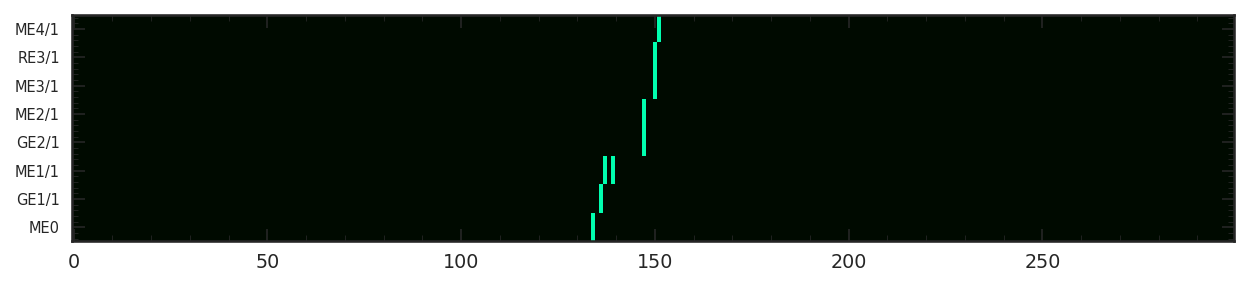

Event 1
pt: 2.49711024644


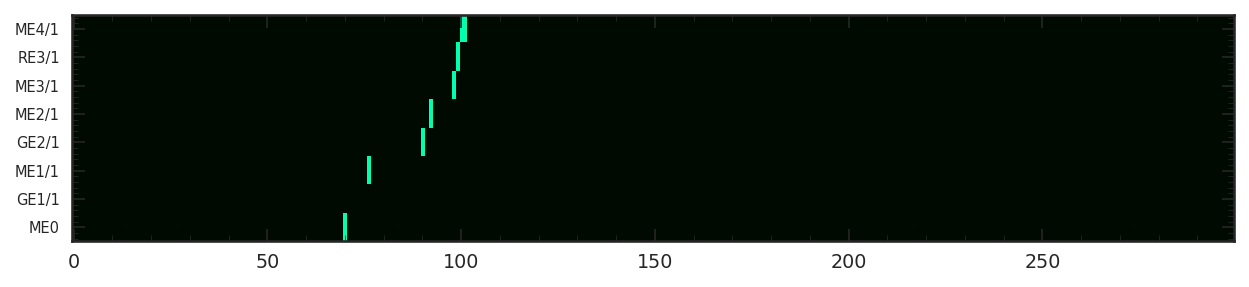

Event 2
pt: 5.66378507264


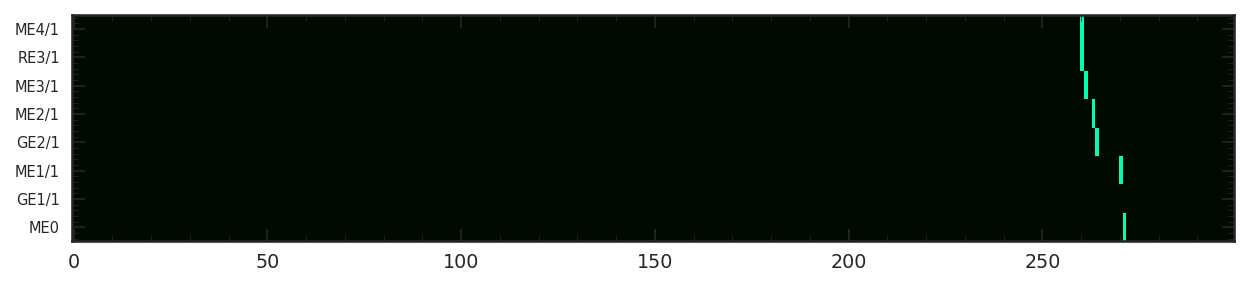

Event 3
pt: 2.88331654986


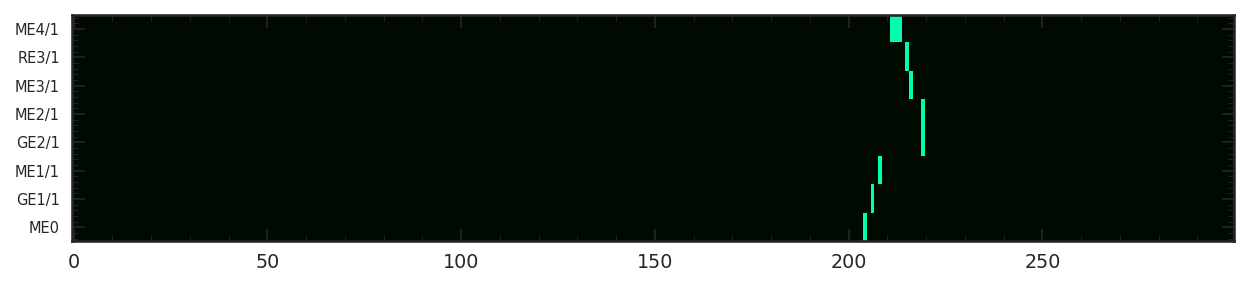

Event 4
pt: 3.21029884748


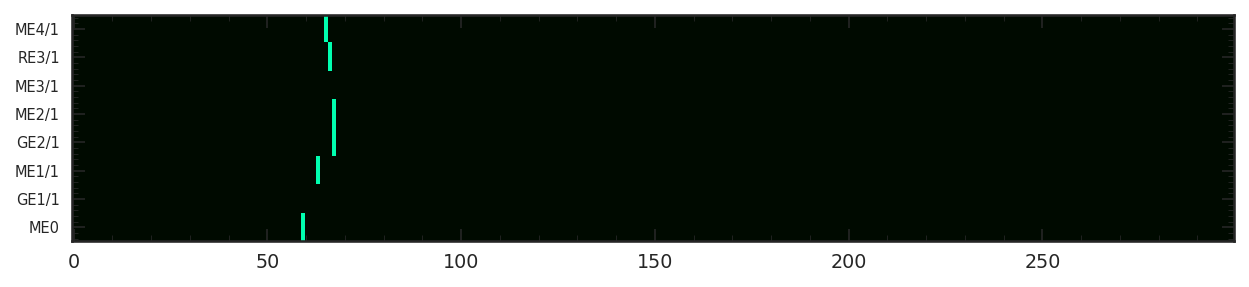

In [16]:
# Debug
for i in range(5):
  print('Event {0}'.format(i))
  print('pt: {0}'.format(1.0/np.abs(zone_part_data[i, 0])))
  display_image(images[i], cmap=green_hot)